In [1]:
from pathlib import Path
from PIL import Image

import numpy as np

In [2]:
def checks(scene_path):
    scene = scene_path.name
    # Check that all videos are there
    dataset_path_videos = [path for path in scene_path.iterdir() if path.name.endswith('.mp4')] 
    assert len(dataset_path_videos) == 21 if not scene == 'cut_roasted_beef' else len(dataset_path_videos) == 20, \
    f'There should be 20 videos for each scene in this dataset. Problem: scene {scene}'

    # Check that all images are there and have the same amount of images
    dataset_path_images = [path.parent / path.stem / 'images' for path in dataset_path_videos]
    assert all([path.exists() for path in dataset_path_images]), 'Not all images folders exist'
    assert len(set([len(list(path.iterdir())) for path in dataset_path_images])) == 1, 'Not all images folders have the same amount of images'

    # Check that there is no corrupted image (OSError)
    for camera_images_path in dataset_path_images:
        for image_path in camera_images_path.iterdir():
            try:
                image = Image.open(image_path)
                image.verify()
            except OSError:
                print(f'Scene {scene} is corrupted. Corrupted image at {image_path}')
                break

In [3]:
dataset_path = Path(f'../../../datasets/dynerf')
for scene_path in dataset_path.iterdir():
    scene = scene_path.name
    print('Checking scene:', scene)
    checks(dataset_path / scene)
    print('OK')
print('All checks passed for all scenes')

Checking scene: flame_steak
OK
Checking scene: cut_roasted_beef
OK
Checking scene: cook_spinach
OK
All checks passed for all scenes


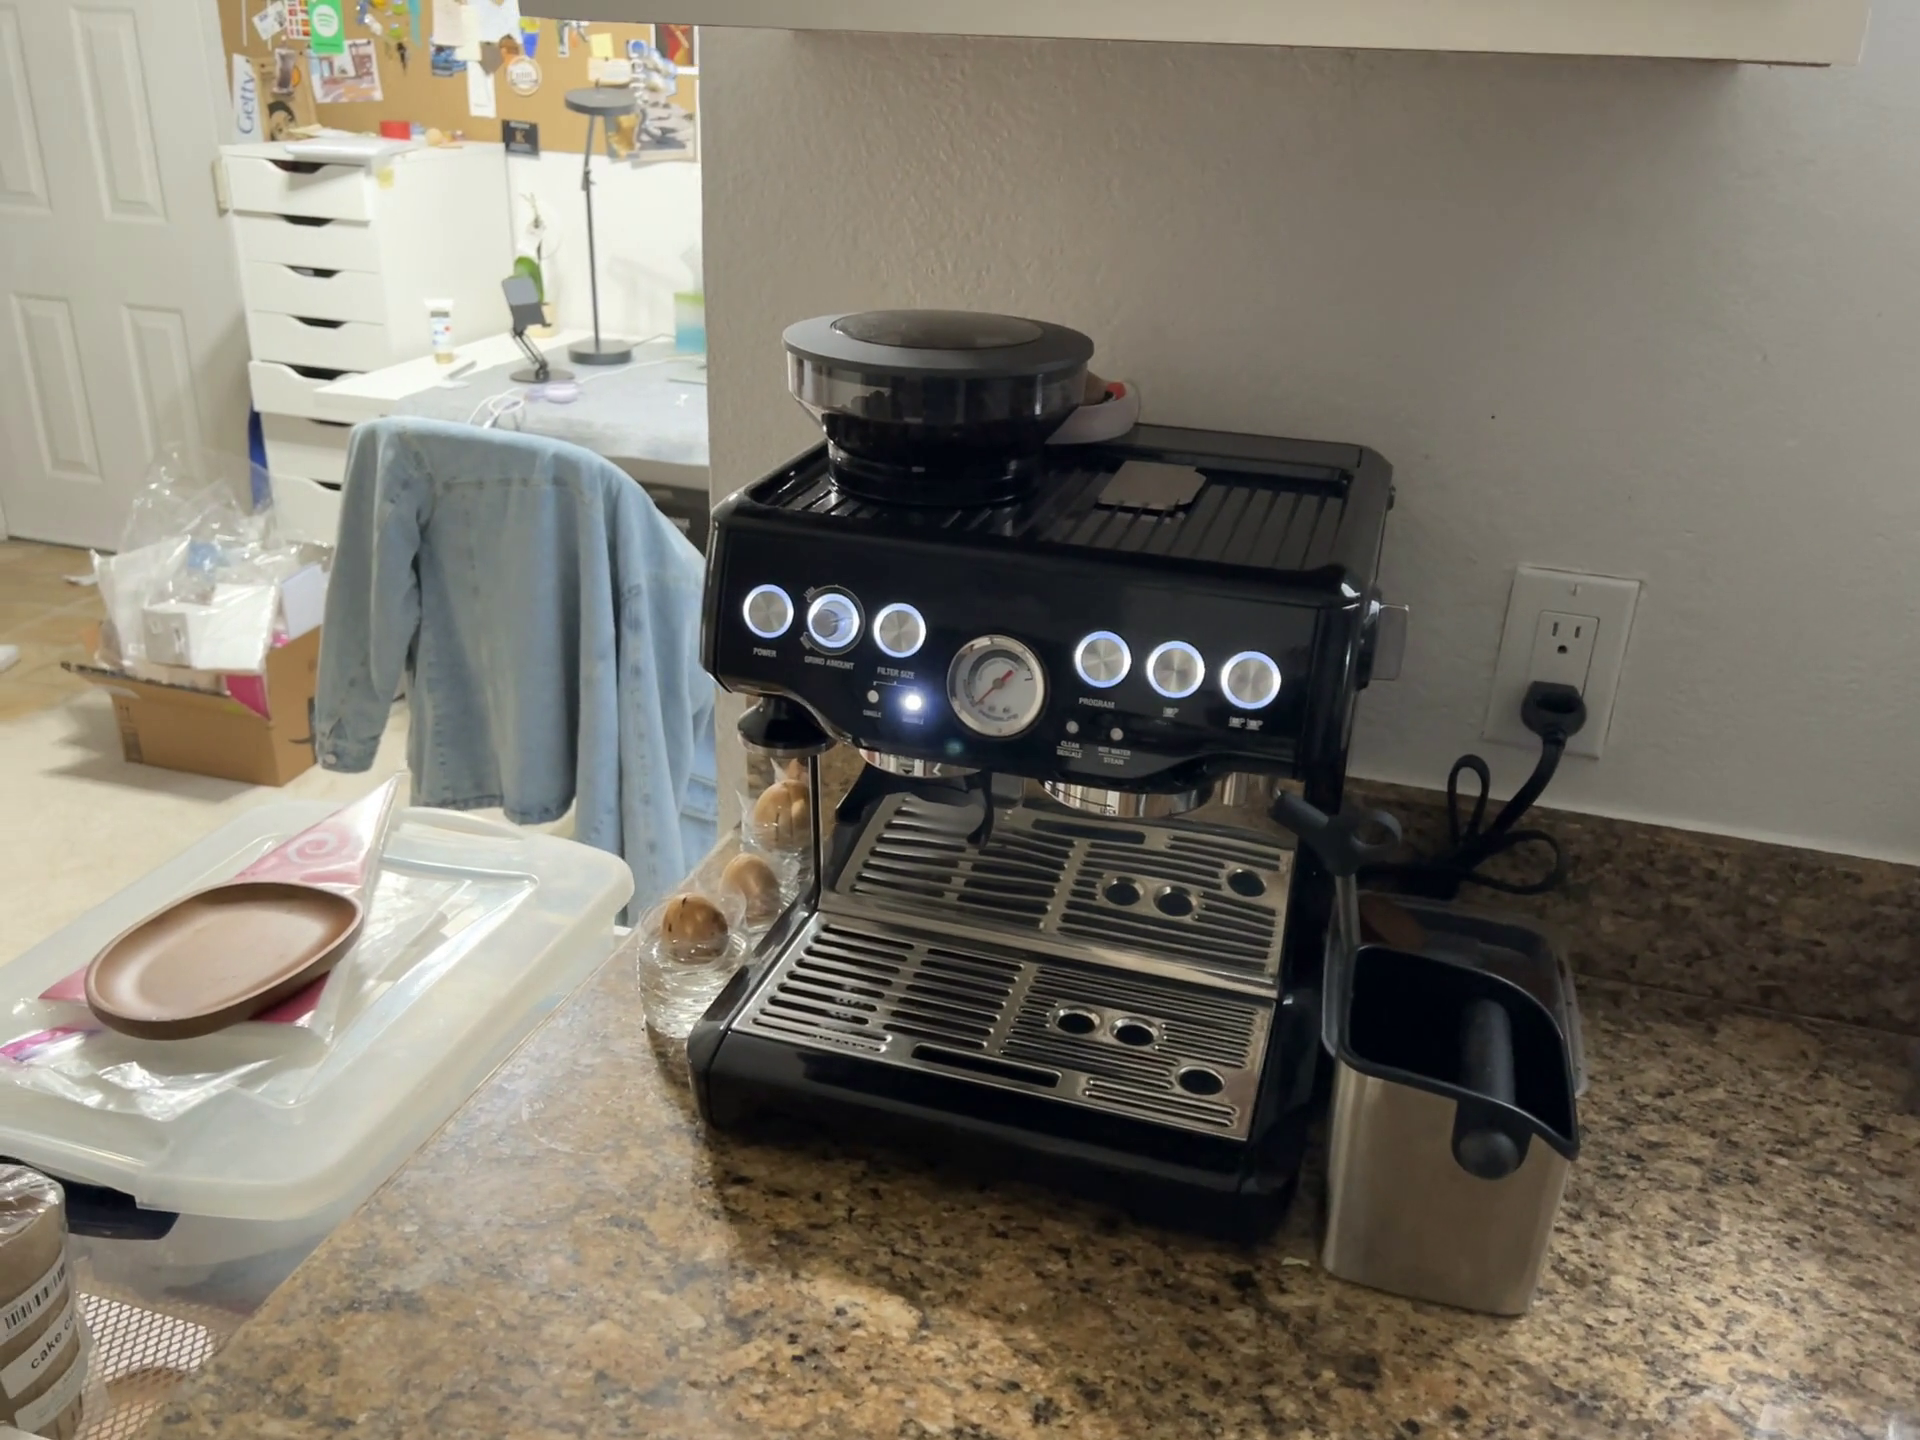

In [16]:
path = Path(f'data/WAT/breville/images/IMG_9185/IMG_9185_370.png')
image = Image.open(path)
image.convert('RGBA')

In [18]:
np.array(image.load()).shape

()

In [19]:
im_data = np.array(image.convert("RGBA"))

In [21]:
im_data.shape

(1440, 1920, 4)

In [2]:
import os
from PIL import Image, ImageFile
import numpy as np
import logging

# Allow loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = False

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_image_robustly(file_path):
    try:
        with Image.open(file_path) as img:
            # Force loading of image data
            img.load()
            
            # Convert to RGB if it's not already
            if img.mode != 'RGB':
                img = img.convert('RGB')
            

            # Convert to numpy array
            np_array = np.array(img)
            
            height, width = img.size
            logging.info(f"Successfully loaded image: {file_path}. Height={height}, width={width}.")
            return np_array
    except (OSError, IOError) as e:
        logging.error(f"Error loading image {file_path}: {str(e)}")
        return None

def process_image_directory(directory):
    successful_loads = 0
    failed_loads = 0
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                result = load_image_robustly(file_path)
                if result is not None:
                    successful_loads += 1
                else:
                    failed_loads += 1
    
    logging.info(f"Processed {successful_loads + failed_loads} images.")
    logging.info(f"Successfully loaded: {successful_loads}")
    logging.info(f"Failed to load: {failed_loads}")

# Usage
image_directory = "data/WAT/breville/images"
process_image_directory(image_directory)

2024-09-13 15:57:42,150 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_590.png. Height=1920, width=1440.
2024-09-13 15:57:42,222 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_480.png. Height=1920, width=1440.
2024-09-13 15:57:42,283 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_420.png. Height=1920, width=1440.
2024-09-13 15:57:42,337 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_290.png. Height=1920, width=1440.
2024-09-13 15:57:42,392 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_140.png. Height=1920, width=1440.
2024-09-13 15:57:42,444 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_270.png. Height=1920, width=1440.
2024-09-13 15:57:42,498 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_430.png. Height=1920, width=1440.
2024-09-13 15:57:42,552 - INFO - Successf

2024-09-13 15:57:45,430 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_170.png. Height=1920, width=1440.
2024-09-13 15:57:45,483 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9185/IMG_9185_310.png. Height=1920, width=1440.
2024-09-13 15:57:45,539 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9187/IMG_9187_200.png. Height=1920, width=1440.
2024-09-13 15:57:45,597 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9187/IMG_9187_170.png. Height=1920, width=1440.
2024-09-13 15:57:45,654 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9187/IMG_9187_130.png. Height=1920, width=1440.
2024-09-13 15:57:45,712 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9187/IMG_9187_420.png. Height=1920, width=1440.
2024-09-13 15:57:45,770 - INFO - Successfully loaded image: data/WAT/breville/images/IMG_9187/IMG_9187_40.png. Height=1920, width=1440.
2024-09-13 15:57:45,828 - INFO - Successfu

In [26]:
import os
from PIL import Image
import torch
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor, as_completed

def validate_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True, file_path
    except Exception as e:
        return False, (file_path, str(e))

def validate_dataset(dataset_path):
    image_files = [os.path.join(root, file) 
                   for root, _, files in os.walk(dataset_path) 
                   for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    valid_images = []
    invalid_images = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(validate_image, file_path) for file_path in image_files]
        for future in as_completed(futures):
            is_valid, result = future.result()
            if is_valid:
                valid_images.append(result)
            else:
                invalid_images.append(result)

    print(f"Total images: {len(image_files)}")
    print(f"Valid images: {len(valid_images)}")
    print(f"Invalid images: {len(invalid_images)}")
    
    if invalid_images:
        print("Invalid images:")
        for file_path, error in invalid_images:
            print(f"  {file_path}: {error}")

    return valid_images, invalid_images

# Usage
dataset_path = "data/WAT/breville/images"
valid_images, invalid_images = validate_dataset(dataset_path)

Total images: 267
Valid images: 267
Invalid images: 0


In [ ]:
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_260.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9186/IMG_9186_410.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9187/IMG_9187_430.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_390.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9186/IMG_9186_0.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_500.png'

'Combinations:'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_260.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9186/IMG_9186_410.png'

'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_390.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9187/IMG_9187_430.png'

'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_310.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_390.png'

'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_260.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9187/IMG_9187_430.png'

'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_260.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9187/IMG_9187_430.png'

'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9187/IMG_9187_430.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_390.png'

'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9187/IMG_9187_430.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_500.png'

'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_260.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9187/IMG_9187_430.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_390.png'

'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9187/IMG_9187_430.png'
'/workspace/4d-gaussian-splatting/data/WAT/breville/images/IMG_9185/IMG_9185_390.png'